<a href="https://colab.research.google.com/github/Ismatulsyantik/Sing-Language-Segmentation-using-Classical-Math-Model/blob/main/FIX_PCD_INSYAALLOH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LOAD DATASET

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import zipfile
import shutil
shutil.copy('/content/drive/MyDrive/PENGOLAHAN_CITRA_DIGITAL/train.zip', '/content/train.zip')
shutil.copy('/content/drive/MyDrive/PENGOLAHAN_CITRA_DIGITAL/test.zip', '/content/test.zip')
shutil.copy('/content/drive/MyDrive/PENGOLAHAN_CITRA_DIGITAL/valid.zip', '/content/valid.zip')

'/content/valid.zip'

In [ ]:
def unzip_file(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        print(f"Extracted: {zip_path} to {extract_to}")

path_train = '/content/train.zip'
path_test = '/content/test.zip'
path_valid = '/content/valid.zip'

os.makedirs('/content/train', exist_ok=True)
os.makedirs('/content/test', exist_ok=True)
os.makedirs('/content/valid', exist_ok=True)

unzip_file(path_train, '/content/train')
unzip_file(path_test, '/content/test')
unzip_file(path_valid, '/content/valid')

Extracted: /content/train.zip to /content/train
Extracted: /content/test.zip to /content/test
Extracted: /content/valid.zip to /content/valid


In [ ]:
paths = [
    '/content/test/test',
    '/content/test/train',
    '/content/valid/valid'
]

for path in paths:
    if os.path.exists(path):
        jpg_count = len([
            f for f in os.listdir(path)
            if f.lower().endswith('.jpg') and os.path.isfile(os.path.join(path, f))
        ])
        print(f"{path}: {jpg_count} .jpg files")
    else:
        print(f"{path}: Folder tidak ditemukan!")


/content/test/test: 203 .jpg files
/content/test/train: 8160 .jpg files
/content/valid/valid: 350 .jpg files


In [ ]:
import pandas as pd
csv_path_test ='/content/test/test/_annotations.csv'
df_test= pd.read_csv(csv_path_test)


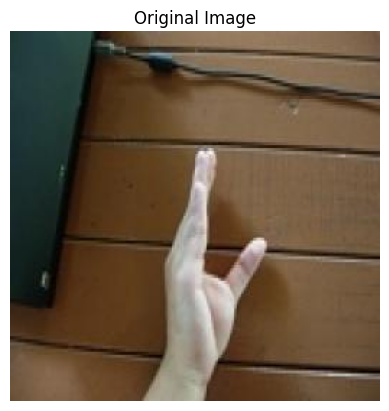

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

img_path = '/content/valid/valid/g-69-_jpg.rf.dd5dc87203707094f53dc2ac90ecf15b.jpg'
image = imread(img_path)

# Tampilkan
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')
plt.show()



In [ ]:
def resize_image(img, size=(256, 256)):
    return img.resize(size, image.BILINEAR)

In [ ]:
import numpy as np

def gaussian_kernel(size=5, sigma=1.0):
    ax = np.arange(-size // 2 + 1., size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    kernel = kernel / np.sum(kernel)
    return kernel


def convolve2d(image, kernel):
    k = kernel.shape[0]
    pad = k // 2

    image_padded = np.pad(image, pad, mode='edge')
    output = np.zeros_like(image)
    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            region = image_padded[i:i+k, j:j+k]
            output[i, j] = np.sum(region * kernel)
    return output

In [ ]:
def gaussian_blur_np(img_np, kernel_size=5, sigma=1.0):
    kernel = gaussian_kernel(kernel_size, sigma)
    blurred = np.zeros_like(img_np, dtype=np.float32)
    for c in range(3):
        blurred[:, :, c] = convolve2d(img_np[:, :, c].astype(np.float32), kernel)
    return np.clip(blurred, 0, 255).astype(np.uint8)

In [ ]:
def histogram_equalization_gray(img_gray):
    hist, bins = np.histogram(img_gray.flatten(), bins=256, range=[0,256])
    cdf = hist.cumsum()
    cdf_masked = np.ma.masked_equal(cdf, 0)
    cdf_min = cdf_masked.min()
    cdf_max = cdf_masked.max()

    cdf_normalized = (cdf_masked - cdf_min) * 255 / (cdf_max - cdf_min)
    cdf_final = np.ma.filled(cdf_normalized, 0).astype(np.uint8)

    img_eq = cdf_final[img_gray]
    return img_eq

In [ ]:
def histogram_equalization_rgb_y_channel(img_np):

    R = img_np[:,:,0].astype(np.float32)
    G = img_np[:,:,1].astype(np.float32)
    B = img_np[:,:,2].astype(np.float32)
    Y  = 0.299 * R + 0.587 * G + 0.114 * B
    Cb = 128 - 0.168736 * R - 0.331264 * G + 0.5 * B
    Cr = 128 + 0.5 * R - 0.418688 * G - 0.081312 * B

    Y_eq = histogram_equalization_gray(Y.astype(np.uint8))

    R_eq = Y_eq + 1.402 * (Cr - 128)
    G_eq = Y_eq - 0.344136 * (Cb - 128) - 0.714136 * (Cr - 128)
    B_eq = Y_eq + 1.772 * (Cb - 128)

    rgb_eq = np.stack([
        np.clip(R_eq, 0, 255),
        np.clip(G_eq, 0, 255),
        np.clip(B_eq, 0, 255),
    ], axis=2).astype(np.uint8)
    return rgb_eq

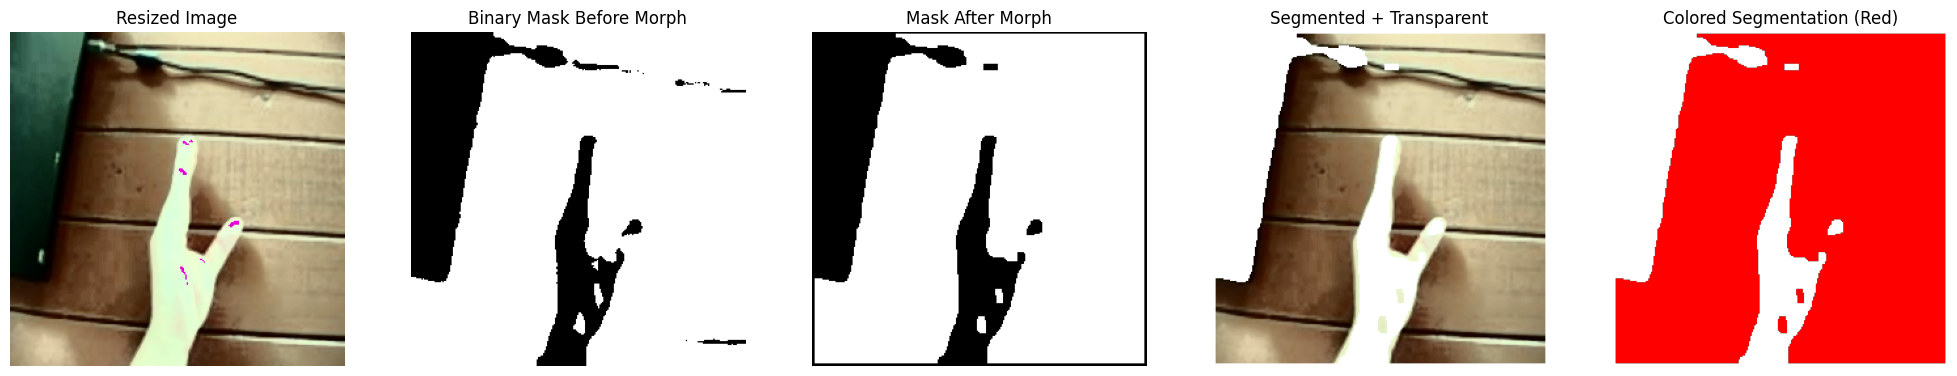

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

img_path = '/content/valid/valid/g-69-_jpg.rf.dd5dc87203707094f53dc2ac90ecf15b.jpg'
output_folder = '/content/Output'
show_sample = True

def resize_image_manual(img_np, size=(256, 256)):
    h_old, w_old = img_np.shape[:2]
    h_new, w_new = size
    scale_x = w_old / w_new
    scale_y = h_old / h_new

    result = np.zeros((h_new, w_new, 3), dtype=np.uint8)
    for i in range(h_new):
        for j in range(w_new):
            x = int(j * scale_x)
            y = int(i * scale_y)
            result[i, j] = img_np[y, x]
    return result


def smooth_image_manual(img_np):
    kernel = np.array([[1, 2, 1],
                       [2, 4, 2],
                       [1, 2, 1]]) / 16.0
    pad_img = np.pad(img_np, ((1, 1), (1, 1), (0, 0)), mode='edge')
    output = np.zeros_like(img_np)

    for y in range(img_np.shape[0]):
        for x in range(img_np.shape[1]):
            for c in range(3):
                region = pad_img[y:y+3, x:x+3, c]
                output[y, x, c] = np.sum(region * kernel)
    return output

def equalize_histogram_manual(img_np):
    R, G, B = img_np[:, :, 0], img_np[:, :, 1], img_np[:, :, 2]
    Y = (0.247 * R + 0.560 * G + 0.350 * B).astype(np.uint8)

    hist, _ = np.histogram(Y, bins=256, range=(0, 256))
    cdf = hist.cumsum()
    cdf_normalized = (cdf - cdf.min()) * 255 / (cdf.max() - cdf.min())
    Y_eq = cdf_normalized[Y].astype(np.uint8)

    Cr = R.astype(np.int16) - Y.astype(np.int16)
    Cb = B.astype(np.int16) - Y.astype(np.int16)

    R_eq = (Y_eq + Cr).clip(0, 255)
    B_eq = (Y_eq + Cb).clip(0, 255)
    G_eq = ((Y_eq - 0.299 * R_eq - 0.114 * B_eq) / 0.587).clip(0, 255)

    img_eq = np.stack([R_eq, G_eq, B_eq], axis=-1).astype(np.uint8)
    return img_eq


def segment_hand_skin_ycrcb_manual(img_np):
    R, G, B = img_np[:, :, 0].astype(np.float32), img_np[:, :, 1].astype(np.float32), img_np[:, :, 2].astype(np.float32)
    Y  = 0.220 * R + 0.550 * G + 0.175 * B
    Cr = (R - Y) * 0.800 + 128
    Cb = (B - Y) * 0.700 + 128

    is_skin = (Cr > 135) & (Cr < 180) & (Cb > 60) & (Cb < 1000)
    return is_skin.astype(np.uint8) * 255


def postprocess_mask_manual(mask_np):
    def erode(img, kernel_size=5):
        pad = kernel_size // 2
        padded = np.pad(img, pad, mode='constant', constant_values=0)
        result = np.zeros_like(img)
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                region = padded[i:i+kernel_size, j:j+kernel_size]
                result[i, j] = np.min(region)
        return result

    def dilate(img, kernel_size=5):
        pad = kernel_size // 2
        padded = np.pad(img, pad, mode='constant', constant_values=0)
        result = np.zeros_like(img)
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                region = padded[i:i+kernel_size, j:j+kernel_size]
                result[i, j] = np.max(region)
        return result

    opened = dilate(erode(mask_np))
    closed = erode(dilate(opened))
    return closed

# Pipeline
def process_image_pipeline(image_path, output_folder=None, show_sample=False):
    img = Image.open(image_path)
    img_np = np.array(img)

    img_smooth = smooth_image_manual(img_np)
    img_equalized = equalize_histogram_manual(img_smooth)
    img_resized = resize_image_manual(img_equalized)

    mask_binary = segment_hand_skin_ycrcb_manual(img_resized)
    mask_cleaned = postprocess_mask_manual(mask_binary)

    h, w = mask_cleaned.shape
    alpha = mask_cleaned

    result_rgba = np.zeros((h, w, 4), dtype=np.uint8)
    result_rgba[:, :, :3] = img_resized
    result_rgba[:, :, 3] = alpha

    color = (255, 0, 0)
    mask_bool = (mask_cleaned > 0).astype(np.uint8)
    colored_seg = np.zeros((h, w, 4), dtype=np.uint8)
    colored_seg[:, :, 0] = color[0] * mask_bool
    colored_seg[:, :, 1] = color[1] * mask_bool
    colored_seg[:, :, 2] = color[2] * mask_bool
    colored_seg[:, :, 3] = alpha

    if output_folder:
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        base_name = os.path.basename(image_path)
        base_name_wo_ext = os.path.splitext(base_name)[0]

        Image.fromarray(result_rgba).save(os.path.join(output_folder, f"segmented_{base_name_wo_ext}_transparent.png"))
        Image.fromarray(colored_seg).save(os.path.join(output_folder, f"segmented_{base_name_wo_ext}_colored.png"))

    if show_sample:
        fig, axes = plt.subplots(1, 5, figsize=(25, 5))
        axes[0].imshow(img_resized)
        axes[0].set_title('Resized Image')
        axes[1].imshow(mask_binary, cmap='gray')
        axes[1].set_title('Binary Mask Before Morph')
        axes[2].imshow(mask_cleaned, cmap='gray')
        axes[2].set_title('Mask After Morph')
        axes[3].imshow(result_rgba)
        axes[3].set_title('Segmented + Transparent')
        axes[4].imshow(colored_seg)
        axes[4].set_title('Colored Segmentation (Red)')
        for ax in axes:
            ax.axis('off')
        plt.show()

process_image_pipeline(img_path, output_folder, show_sample)